In [ ]:
!pip install torch torchvision datasets transformers albumentations
!pip install -U git+https://github.com/luca-medeiros/lang-segment-anything.git

  Using cached huggingface_hub-0.22.2-py3-none-any.whl (388 kB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.16.4
    Uninstalling huggingface-hub-0.16.4:
      Successfully uninstalled huggingface-hub-0.16.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lang-sam 0.1.0 requires huggingface-hub<0.17.0,>=0.16.4, but you have huggingface-hub 0.22.2 which is incompatible.
  Cloning https://github.com/luca-medeiros/lang-segment-anything.git to /tmp/pip-req-build-9g52asnp
  Running command git clone --filter=blob:none --quiet https://github.com/luca-medeiros/lang-segment-anything.git /tmp/pip-req-build-9g52asnp
  Resolved https://github.com/luca-medeiros/lang-segment-anything.git to commit f4ca2960a97cb73aff2c459a9d0f06c7674452e4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  P

In [ ]:
!pip install datasets

  Using cached huggingface_hub-0.22.2-py3-none-any.whl (388 kB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.16.4
    Uninstalling huggingface-hub-0.16.4:
      Successfully uninstalled huggingface-hub-0.16.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lang-sam 0.1.0 requires huggingface-hub<0.17.0,>=0.16.4, but you have huggingface-hub 0.22.2 which is incompatible.


In [ ]:
from PIL import Image
import torch
from torchvision import transforms as tvt

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [ ]:
from PIL import Image
import torch
from torchvision import transforms as tvt

image_pil = Image.open("rs00054.jpg").convert("RGB")
print(image_pil.size)

plt.imshow(image_pil)
plt.axis("off")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'rs00054.jpg'

In [ ]:
mytransforms = tvt.Compose([tvt.PILToTensor(),
                           tvt.CenterCrop(size=(1024, 1024))])
tr_img = mytransforms(image_pil)
print(tr_img.shape)

plt.imshow(tr_img.permute(1, 2, 0).numpy())
plt.axis("off")
plt.show()

In [ ]:
mytransforms = tvt.Compose([tvt.PILToTensor(),
                           tvt.FiveCrop(size=(1024, 1024))])
tr_img = mytransforms(image_pil)
print(type(tr_img), len(tr_img))

fig, ax = plt.subplots(1, 5, figsize=(15, 10))
print(len(ax.flat), ax.shape)

for i, img in enumerate(tr_img):
    ax[i].imshow(img.permute(1, 2, 0).numpy())
    print(img.shape)
    ax[i].axis("off")

In [ ]:
mytransforms = tvt.Compose([tvt.PILToTensor(),
                           tvt.FiveCrop(size=(512, 512))])
tr_img = mytransforms(image_pil)
print(type(tr_img), len(tr_img))

fig, ax = plt.subplots(1, 5, figsize=(15, 10))
print(len(ax.flat), ax.shape)

for i, img in enumerate(tr_img):
    ax[i].imshow(img.permute(1, 2, 0).numpy())
    print(img.shape)
    ax[i].axis("off")

In [ ]:
from huggingface_hub import login
from google.colab import userdata

login(token=userdata.get('HF_TOKEN'))

Token has not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
import torch
import torchvision.transforms as tvt
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision
from torchvision.transforms.functional import crop
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F


class PatchQueue(Dataset):
    def __init__(
            self, dataset, max_length, # Queue Length
            samples_per_image, # Patches per image
            queue_workers = 1, # Num Workers
            patch_size = [512, 512], # Patch Size
            shuffle = False
        ):
        self.dataset = dataset
        self.max_length = max_length
        self.queue_workers = queue_workers
        self.samples_per_image = samples_per_image
        self.shuffle_queue = shuffle
        self.patch_size = patch_size
        self._images_iterable = None
        self.patch_list = []
        self._num_sampled_images = 0
        self.steps_per_epoch = len(self.dataset) * self.samples_per_image
        self.resize_transform = tvt.Resize(patch_size[::-1])  # Reverse patch_size for Resize
        self.fivecrop_transform = tvt.FiveCrop(size=(1024, 1024))

    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, item):
        if not self.patch_list:
            print("Patch List is empty.")
            self._fill()
            self.patch_list.reverse()
        sample_patch = self.patch_list.pop()
        return sample_patch

    @staticmethod
    def _get_first_item(batch):
        print("_get_first_item")
        if isinstance(batch[0], dict):
            print(batch[0].keys())
        else:
            print(batch[0])
        return batch[0]

    def initialize_images_iterable(self):
        self._images_iterable = self._get_images_iterable()

    @property
    def images_iterable(self):
        if self._images_iterable is None:
            self.initialize_images_iterable()
        return self.images_iterable

    def _get_images_iterable(self):
        print(f"dataloader datset : {len(self.dataset)}")

        loader = DataLoader(self.dataset,
                            num_workers = self.queue_workers,
                            batch_size=1,
                            collate_fn=self._get_first_item,
                            shuffle = self.shuffle_queue
                            ) #make it ddp compatible
        self._num_sampled_images = 0
        return iter(loader)

    def _get_next_image(self):
        try:
            image = next(self._images_iterable)
        except Exception as e:
            print(f"Excepton: {e}")
            self.initialize_images_iterable()
            image = next(self._images_iterable)
        return image

    def extract_patches(self, image_pair, samples_per_image, patch_size):
        image_patches = []
        img_height, img_width = image_pair['image'].shape[-2], image_pair['image'].shape[-1]
        # Check if image size is smaller than patch size
        if img_height < patch_size[0] or img_width < patch_size[1]:
            # Resize the image to match the patch size if its size is less than patchsize
            image_pair['image'] = self.resize_transform(image_pair['image'])
            image_pair['mask'] = self.resize_transform(image_pair['mask'])
            img_height, img_width = image_pair['image'].shape[-2], image_pair['image'].shape[-1]
        cropped_imgs = self.fivecrop_transform(image_pair['image']) #tl, tr, bl, br, cntr
        cropped_masks = self.fivecrop_transform(image_pair['mask'])
        for i in range(samples_per_image):
            image_patches.append({'image': cropped_imgs[i], 'mask': cropped_masks[i]})

        # for i in range(samples_per_image):
            # left = torch.randint(low=0, high=img_width-patch_size[0], size=[1,]).item()
            # top = torch.randint(low=0, high=img_height-patch_size[1], size=[1,]).item()
            # cropped_image = crop(img=image_pair['image'], top=top, left=left, height=patch_size[1], width=patch_size[0])
            # cropped_labels = crop(img=image_pair['mask'], top=top, left=left, height=patch_size[1], width=patch_size[0])
            # image_patches.append({'image':cropped_image, 'mask':cropped_labels})
        return image_patches


    def _fill(self):
        while True:
            print("Extract patches fill function")
            image_pair = self._get_next_image()
            samples_per_image = self.samples_per_image
            patch_size = self.patch_size
            patches = self.extract_patches(image_pair, samples_per_image,patch_size)
            self.patch_list.extend(patches)
            self._num_sampled_images += 1
            islistfull = len(self.patch_list) >= self.max_length
            print("end")
            print(len(self.patch_list))
            for i, patch in enumerate(self.patch_list):
                print(i, patch.keys(), patch["image"].shape, patch["mask"].shape)
            if islistfull:
                break

In [ ]:
import datasets
from datasets import load_dataset
from pathlib import Path
from huggingface_hub import hf_hub_download
import pandas as pd

def load_railsem_dataset():
    print(f"[INFO]: Extracting Railsem19 dataset")
    railsem_ds = load_dataset("BhavanaMalla/railsem19-semantic-expanded")
    return railsem_ds

def load_splits():
    print("[INFO]: Loading splits")
    data_directory = Path(".")
    csv_file_path = data_directory / "RAIL_SEM19_split.csv"
    if csv_file_path.is_file():
        print(f"[INFO]: Found {csv_file_path}.Skipping Download...")
    else:
        print("[INFO]: Downloading RAIL_SEM19_split.csv from hub")
        csv_file_path = hf_hub_download(
            repo_id="BhavanaMalla/railsem19-semantic-expanded",
            filename="RAIL_SEM19_split.csv",
            repo_type="dataset",
            local_dir=data_directory
        )
    splits_df = pd.read_csv(csv_file_path)

    # Filter rows based on type
    train_names = splits_df[splits_df["type"] == "Train"]["Names"].tolist()
    val_names = splits_df[splits_df["type"] == "Validation"]["Names"].tolist()
    test_names = splits_df[splits_df["type"] == "Test"]["Names"].tolist()
    return train_names, val_names, test_names

class CustomDataset(Dataset):
    def __init__(self, dataset, transforms=None):
        self.dataset = dataset
        self.transforms = transforms

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]["image"]
        semantic_mask = self.dataset[idx]["semantic_mask_label"]
        image_name = self.dataset[idx]["img_Name"]
        if self.transforms:
            image_transforms, mask_transforms = self.transforms
            transformed_image = image_transforms(image)
            transformed_mask = mask_transforms(semantic_mask)
        else:
            image_transforms, mask_transforms = get_transforms()
            transformed_image = image_transforms(image)
            transformed_mask = mask_transforms(semantic_mask)
        return {
            "image": transformed_image, "mask": transformed_mask,
            "name": image_name
        }

def get_fpn_transforms():
    # Transforms
    image_transforms = tvt.Compose([tvt.ToTensor(),
                                    # tvt.CenterCrop(size=1024),
                                ])
    mask_transforms = tvt.Compose([tvt.PILToTensor(),
                                #   RemapBackground(),
                                #   RemapLabels(),
                                #   tvt.CenterCrop(size=1024),
                                ])
    return image_transforms, mask_transforms

In [ ]:
dataset = load_railsem_dataset()["data"] # Get the dataset

total_size = len(dataset)

train_names, val_names, test_names = load_splits() # Get the splits
train_idxs, val_idxs, test_idxs = [], [], []
dataset.map(
    lambda img, idx: (
        train_idxs.append(idx) if img["img_Name"] in train_names
        else val_idxs.append(idx) if img["img_Name"] in val_names
        else test_idxs.append(idx) if img["img_Name"] in test_names
        else None), with_indices=True
)
train_split = dataset.select(train_idxs)
val_split = dataset.select(val_idxs)
test_split = dataset.select(test_idxs)

print(f"[INFO]: Total images: {total_size}")
print(f"[INFO]: Total Training images: {len(train_split)}")
print(f"[INFO]: Total Validation images: {len(val_split)}")
print(f"[INFO]: Total Test images: {len(test_split)}")

[INFO]: Extracting Railsem19 dataset
[INFO]: Loading splits
[INFO]: Found RAIL_SEM19_split.csv.Skipping Download...


Map:   0%|          | 0/8500 [00:00<?, ? examples/s]

[INFO]: Total images: 8500
[INFO]: Total Training images: 5950
[INFO]: Total Validation images: 765
[INFO]: Total Test images: 1785


In [ ]:
transforms = get_fpn_transforms()

# Custom Dataset
train_dataset = CustomDataset(train_split.select(indices=(range(2))), transforms)
val_dataset = CustomDataset(val_split, transforms)
test_dataset = CustomDataset(test_split, transforms)

patch_size = [1024, 1024]
print(f"[INFO]: Creating {patch_size} Patches")
samples_per_image = 5
train_queue = PatchQueue(dataset=train_dataset, max_length=10,
                         samples_per_image=samples_per_image,
                         patch_size=patch_size)
val_queue = PatchQueue(dataset=val_dataset, max_length=10,
                       samples_per_image=samples_per_image,
                       patch_size=patch_size)
test_queue = PatchQueue(dataset=test_dataset, max_length=10,
                        samples_per_image=samples_per_image,
                        patch_size=patch_size)



[INFO]: Creating [1024, 1024] Patches


In [ ]:
len(train_dataset), len(train_queue) #5950x5,

(2, 10)

In [ ]:
train_dataset[0].keys()

dict_keys(['image', 'mask', 'name'])

Patch List is empty.
Extract patches fill function
Excepton: 'NoneType' object is not an iterator
dataloader datset : 2
_get_first_item
dict_keys(['image', 'mask', 'name'])
end
5
0 dict_keys(['image', 'mask']) torch.Size([3, 1024, 1024]) torch.Size([1, 1024, 1024])
1 dict_keys(['image', 'mask']) torch.Size([3, 1024, 1024]) torch.Size([1, 1024, 1024])
2 dict_keys(['image', 'mask']) torch.Size([3, 1024, 1024]) torch.Size([1, 1024, 1024])
3 dict_keys(['image', 'mask']) torch.Size([3, 1024, 1024]) torch.Size([1, 1024, 1024])
4 dict_keys(['image', 'mask']) torch.Size([3, 1024, 1024]) torch.Size([1, 1024, 1024])
Extract patches fill function
_get_first_item
dict_keys(['image', 'mask', 'name'])
end
10
0 dict_keys(['image', 'mask']) torch.Size([3, 1024, 1024]) torch.Size([1, 1024, 1024])
1 dict_keys(['image', 'mask']) torch.Size([3, 1024, 1024]) torch.Size([1, 1024, 1024])
2 dict_keys(['image', 'mask']) torch.Size([3, 1024, 1024]) torch.Size([1, 1024, 1024])
3 dict_keys(['image', 'mask']) torc

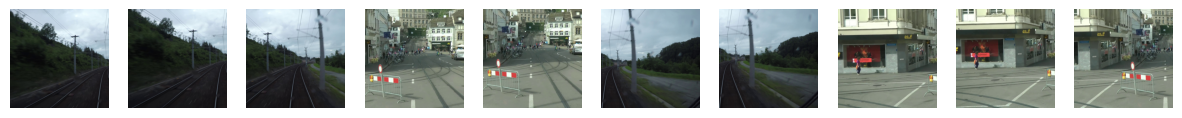

In [ ]:
dataloader = DataLoader(train_queue,
                        batch_size=2,
                        pin_memory=True,
                        drop_last=True)


tr_img = []
tr_img_1 = []
tr_mask = []
tr_mask_1 = []
for i, batch in enumerate(dataloader):
    print("actual dataloader")
    print(batch.keys(), batch["image"].shape, batch["mask"].shape)
    tr_img.append(batch["image"][0].squeeze())
    tr_img_1.append(batch["image"][1].squeeze())
    tr_mask.append(batch["mask"][0].squeeze())
    tr_mask_1.append(batch["mask"][1].squeeze())

final_imgs = tr_img + tr_img_1
final_masks = tr_mask + tr_mask_1
print(len(final_imgs), len(final_masks))
fig, ax = plt.subplots(1, 10, figsize=(15, 10))
for i, img in enumerate(final_imgs): #tr_img
    print(img.shape)
    ax[i].imshow(img.permute(1, 2, 0).numpy())
    ax[i].axis("off")
plt.show()


In [ ]:
import torch
import torchvision.transforms as tvt
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision
from torchvision.transforms.functional import crop
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random

class PatchQueue(Dataset):
    def __init__(self, dataset, max_length,  # Queue Length
                 samples_per_image,  # Patches per image
                 queue_workers=4,  # Num Workers
                 patch_size=[512, 512],  # Patch Size
                 padding=False,
                 shuffle=False):
        self.dataset = dataset
        self.max_length = max_length
        self.queue_workers = queue_workers
        self.samples_per_image = samples_per_image
        self.shuffle_queue = shuffle
        self.patch_size = patch_size
        self._images_iterable = None
        self.patch_list = list()
        self._num_sampled_images = 0
        self.padding = padding
        self.steps_per_epoch = len(self.dataset) * self.samples_per_image
        self.resize_transform = tvt.Resize(patch_size[::-1])
        if self.samples_per_image == 1:
            print("center crop")
            self.crop_transform = tvt.CenterCrop(size=1024)
        elif self.samples_per_image > 1:
            self.crop_transform = tvt.FiveCrop(size=(1024, 1024))
        self.transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            # A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.ColorJitter(brightness=0.2, contrast=0.2, hue=0.2, saturation=0.2, p=0.5, always_apply=False),
            # ], p=1),
            ToTensorV2()  # Convert the augmented image to a PyTorch tensor
        ])


    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, item):
        if not self.patch_list:
            print("[WARN]: Patch List is empty...")
            self._fill()
            self.patch_list.reverse()
        sample_patch = self.patch_list.pop()
        return sample_patch

    @staticmethod
    def _get_first_item(batch):
        return batch[0]

    def initialize_images_iterable(self):
        self._images_iterable = self._get_images_iterable()

    @property
    def num_patches(self) -> int:
        return len(self.patch_list)

    @property
    def images_iterable(self):
        if self._images_iterable is None:
            self.initialize_images_iterable()
        return self.images_iterable

    def _get_images_iterable(self):
        if torch.distributed.is_available() and torch.distributed.is_initialized():
            sampler = torch.utils.data.DistributedSampler(
                self.dataset,
                num_replicas=torch.distributed.get_world_size(),
                rank=torch.distributed.get_rank(), shuffle=self.shuffle_queue
            )
        else:
            sampler = None
        loader = DataLoader(
            self.dataset,  # num_workers=self.queue_workers, #in multigpu, >0 not wrkng
            batch_size=1, collate_fn=self._get_first_item, pin_memory=True,
            shuffle=True,#self.shuffle_queue,
            sampler=sampler
        )
        self._num_sampled_images = 0
        return iter(loader)

    def _get_next_image(self):
        try:
            image = next(self._images_iterable)
        except Exception as e:
            print(f"[WARN]:Exception while getting image for patching: {e}")
            self.initialize_images_iterable()
            image = next(self._images_iterable)
        return image

    def extract_patches(self, image_pair, samples_per_image, patch_size):
        image_patches = []
        img_height = image_pair['image'].shape[-2]
        img_width = image_pair['image'].shape[-1]
        # Check if image size is smaller than patch size
        if img_height < patch_size[0] or img_width < patch_size[1]:
            # Resize the image to match the patch size
            image_pair["image"] = self.resize_transform(image_pair["image"])
            image_pair["mask"] = self.resize_transform(image_pair["mask"])
            img_height = image_pair["image"].shape[-2]
            img_width = image_pair["image"].shape[-1]
        # cropped_imgs = self.fivecrop_transform(image_pair['image']) #tl, tr, bl, br, cntr
        # cropped_masks = self.fivecrop_transform(image_pair['mask'])
        cropped_imgs = self.crop_transform(image_pair['image']) #tl, tr, bl, br, cntr
        cropped_masks = self.crop_transform(image_pair['mask'])
        cropped_img_name = image_pair["name"]
        print(f"cropped images length: {len(cropped_imgs)}")
        if samples_per_image > 1:
            for i in range(samples_per_image):
                print(f"Orignal: {cropped_imgs[i].shape, cropped_masks[i].shape}") #torch.Size([3, 1024, 1024]) torch.Size([1, 1024, 1024])
                img = cropped_imgs[i]
                mask = cropped_masks[i]
                if i < samples_per_image - 1:
                    img_np = img.permute(1, 2, 0).cpu().numpy()  # Assuming tensor is on GPU
                    mask_np = mask.squeeze().cpu().numpy()
                    print(f"Numpy Permute: {img_np.shape, mask_np.shape}")
                    # Apply transformations
                    transformed = self.transform(image=img_np, mask=mask_np)
                    # Convert the transformed image back to PyTorch tensor
                    print(f"transformed album: {transformed['image'].shape, transformed['mask'].shape}") #(torch.Size([3, 1024, 1024]), torch.Size([1024, 1024]))
                    img_trans = transformed['image']#.permute(2, 0, 1)  # Assuming you want the tensors on GPU
                    mask_trans = transformed['mask'][None, :, :]  # Assuming you want the tensors on GPU
                    print(f"transformed album after permute: {img_trans.shape, mask_trans.shape}")
                    image_patches.append({"image": img_trans,
                                        "mask": mask_trans,
                                        "name": cropped_img_name})
                else:
                    # Append the last image crop which is center without photometric transformation
                    image_patches.append({"image": img, "mask": mask, "name": cropped_img_name})
        else:
            print(f"Orignal: {cropped_imgs.shape, cropped_masks.shape}")
            img = cropped_imgs
            mask = cropped_masks
            img_np = img.permute(1, 2, 0).cpu().numpy()  # Assuming tensor is on GPU
            mask_np = mask.squeeze().cpu().numpy()
            print(f"Numpy Permute: {img_np.shape, mask_np.shape}")
            transformed = self.transform(image=img_np, mask=mask_np)
            print(f"transformed album: {transformed['image'].shape, transformed['mask'].shape}") #(torch.Size([3, 1024, 1024]), torch.Size([1024, 1024]))
            img_trans = transformed['image']
            mask_trans = transformed['mask'][None, :, :]
            print(f"transformed album after permute: {img_trans.shape, mask_trans.shape}")
            image_patches.append({"image": img_trans,
                                "mask": mask_trans,
                                "name": cropped_img_name})
        return image_patches

    def _fill(self):
        while True:
            image_pair = self._get_next_image()
            patch_size = self.patch_size
            samples_per_image = self.samples_per_image
            patches = self.extract_patches(
                image_pair, samples_per_image, patch_size
            )
            self.patch_list.extend(patches)
            self._num_sampled_images += 1
            islistfull = len(self.patch_list) >= self.max_length
            if islistfull:
                break

        self._shuffle_patches_list()

    def _shuffle_patches_list(self):
        print(f"Num patches len: {self.num_patches}")
        indices = torch.randperm(self.num_patches)
        self.patch_list = [self.patch_list[i] for i in indices]

In [ ]:
transforms = get_fpn_transforms()

# Custom Dataset
train_dataset = CustomDataset(train_split.select(indices=(range(10))), transforms)
val_dataset = CustomDataset(val_split, transforms)
test_dataset = CustomDataset(test_split, transforms)

patch_size = [1024, 1024]
print(f"[INFO]: Creating {patch_size} Patches")
samples_per_image = 5
train_queue = PatchQueue(dataset=train_dataset, max_length=10,
                         samples_per_image=samples_per_image,
                         patch_size=patch_size)
val_queue = PatchQueue(dataset=val_dataset, max_length=10,
                       samples_per_image=samples_per_image,
                       patch_size=patch_size)
test_queue = PatchQueue(dataset=test_dataset, max_length=10,
                        samples_per_image=samples_per_image,
                        patch_size=patch_size)



[INFO]: Creating [1024, 1024] Patches


In [ ]:
dataloader = DataLoader(train_queue,
                        batch_size=3,
                        pin_memory=True,
                        drop_last=True,
                        shuffle=True)

for i, batch in enumerate(dataloader):
    print("actual dataloader")
    print(batch.keys(), batch["image"].shape, batch["mask"].shape)
    num_images = batch["image"].shape[0]  # Number of images in the batch
    num_rows = 1  # Number of rows for displaying images in a batch

    fig, axes = plt.subplots(num_rows, 2*num_images, figsize=(15, num_rows * 5))

    for j in range(num_images):  # Iterate over each image in the batch
        # Plot the image
        axes[j].imshow(batch["image"][j].permute(1, 2, 0).numpy())  # Assuming image is in channel-last format
        axes[j].set_title('Image')
        axes[j].axis('off')

        # Plot the mask
        axes[j + num_images].imshow(batch["mask"][j][0].numpy(), cmap='gray')  # Assuming mask is a single channel
        axes[j + num_images].set_title('Mask')
        axes[j + num_images].axis('off')

    plt.tight_layout()  # Adjust subplot layout
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
len(dataloader), len(train_dataset), len(train_queue), len(tr_mask), len(tr_img)

(16, 10, 50, 48, 48)

In [ ]:
transforms = get_fpn_transforms()

# Custom Dataset
train_dataset = CustomDataset(train_split.select(indices=(range(10))), transforms)
val_dataset = CustomDataset(val_split, transforms)
test_dataset = CustomDataset(test_split, transforms)

patch_size = [1024, 1024]
print(f"[INFO]: Creating {patch_size} Patches")
samples_per_image = 1
train_queue = PatchQueue(dataset=train_dataset, max_length=10,
                         samples_per_image=samples_per_image,
                         patch_size=patch_size)
val_queue = PatchQueue(dataset=val_dataset, max_length=10,
                       samples_per_image=samples_per_image,
                       patch_size=patch_size)
test_queue = PatchQueue(dataset=test_dataset, max_length=10,
                        samples_per_image=samples_per_image,
                        patch_size=patch_size)



[INFO]: Creating [1024, 1024] Patches
center crop
center crop
center crop


[WARN]: Patch List is empty...
[WARN]:Exception while getting image for patching: 'NoneType' object is not an iterator
cropped images length: 3
Orignal: (torch.Size([3, 1024, 1024]), torch.Size([1, 1024, 1024]))
Numpy Permute: ((1024, 1024, 3), (1024, 1024))
transformed album: (torch.Size([3, 1024, 1024]), torch.Size([1024, 1024]))
transformed album after permute: (torch.Size([3, 1024, 1024]), torch.Size([1, 1024, 1024]))
cropped images length: 3
Orignal: (torch.Size([3, 1024, 1024]), torch.Size([1, 1024, 1024]))
Numpy Permute: ((1024, 1024, 3), (1024, 1024))
transformed album: (torch.Size([3, 1024, 1024]), torch.Size([1024, 1024]))
transformed album after permute: (torch.Size([3, 1024, 1024]), torch.Size([1, 1024, 1024]))
cropped images length: 3
Orignal: (torch.Size([3, 1024, 1024]), torch.Size([1, 1024, 1024]))
Numpy Permute: ((1024, 1024, 3), (1024, 1024))
transformed album: (torch.Size([3, 1024, 1024]), torch.Size([1024, 1024]))
transformed album after permute: (torch.Size([3, 102

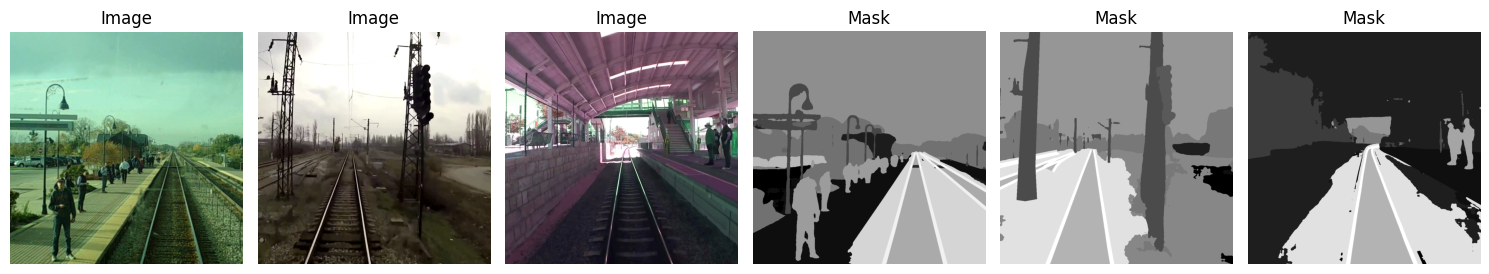

actual dataloader
dict_keys(['image', 'mask', 'name']) torch.Size([3, 3, 1024, 1024]) torch.Size([3, 1, 1024, 1024])


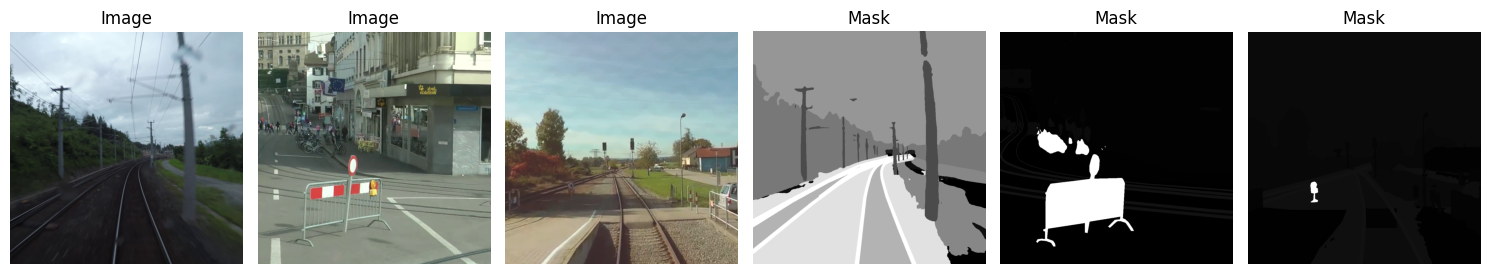

actual dataloader
dict_keys(['image', 'mask', 'name']) torch.Size([3, 3, 1024, 1024]) torch.Size([3, 1, 1024, 1024])


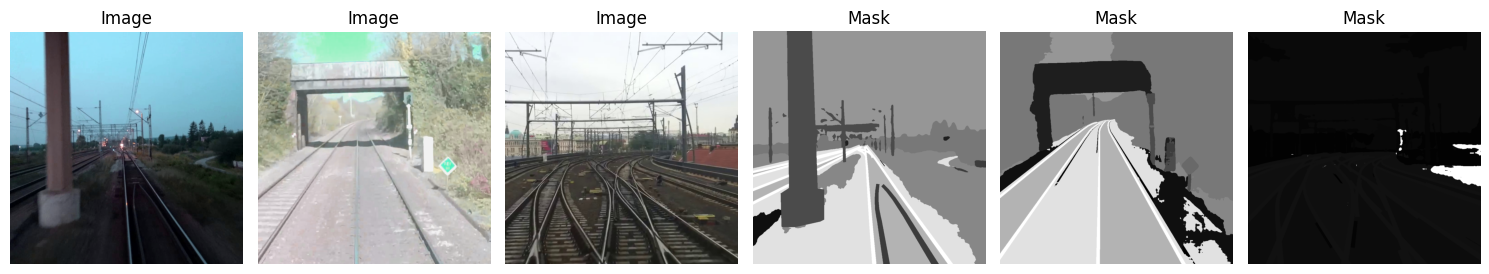

In [ ]:
dataloader = DataLoader(train_queue,
                        batch_size=3,
                        pin_memory=True,
                        drop_last=True,
                        shuffle=True)

for i, batch in enumerate(dataloader):
    print("actual dataloader")
    print(batch.keys(), batch["image"].shape, batch["mask"].shape)
    num_images = batch["image"].shape[0]  # Number of images in the batch
    num_rows = 1  # Number of rows for displaying images in a batch

    fig, axes = plt.subplots(num_rows, 2*num_images, figsize=(15, num_rows * 5))

    for j in range(num_images):  # Iterate over each image in the batch
        # Plot the image
        axes[j].imshow(batch["image"][j].permute(1, 2, 0).numpy())  # Assuming image is in channel-last format
        axes[j].set_title('Image')
        axes[j].axis('off')

        # Plot the mask
        axes[j + num_images].imshow(batch["mask"][j][0].numpy(), cmap='gray')  # Assuming mask is a single channel
        axes[j + num_images].set_title('Mask')
        axes[j + num_images].axis('off')

    plt.tight_layout()  # Adjust subplot layout
    plt.show()


In [ ]:
from PIL import Image
from lang_sam import LangSAM

model = LangSAM()
image_pil = Image.open("rs00048.jpg").convert("RGB")
text_prompt = "on track"
masks, boxes, phrases, logits = model.predict(image_pil, text_prompt)

In [ ]:
import torch
masks.shape, torch.unique(masks)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions(images, ground_truth_mask, predicted_mask, palette):
    palette = np.array(palette)
    num_images = 2 #len(images)

    cols = 3  # 3 cols: original image, gt mask, segmentation mask

    # Create a subplot with num_images rows and 3 columns, make it 5 if you want classes
    fig, axes = plt.subplots(num_images, cols, figsize=(15, 5*num_images))
    # Titles
    axes[0, 0].set_title("Original Image")
    axes[0, 1].set_title("Ground Truth Mask")
    axes[0, 2].set_title("Predicted Mask")

    for i, (img, gt_mask, pred_mask) in enumerate(zip(images, ground_truth_mask, predicted_mask)):
        gt_classes_map = np.unique(gt_mask).tolist()
        pred_classes_map = np.unique(pred_mask).tolist()
        print(pred_classes_map)
        print(pred_mask.shape)
        color_seg = np.zeros((pred_mask.shape[0], pred_mask.shape[1], 3), dtype=np.uint8) # height, width, 3
        color_seg_gt = np.zeros((pred_mask.shape[0], pred_mask.shape[1], 3), dtype=np.uint8)
        for label, color in enumerate(palette):
            color_seg[pred_mask == label, :] = color
            color_seg_gt[gt_mask == label, :] = color

        # Convert to BGR
        color_seg = color_seg[..., ::-1]
        color_seg_gt = color_seg_gt[..., ::-1]

        # Show image + mask of prediction
        img_pred = np.array(img) * 0.5 + color_seg * 0.5
        img_pred = img_pred.astype(np.uint8)

        # Show image + mask of gt
        img_gt = np.array(img) * 0.5 + color_seg_gt * 0.5
        img_gt = img_gt.astype(np.uint8)

        # Plot original image
        axes[i, 0].imshow(img)
        # Plot ground truth mask
        axes[i, 1].imshow(img_gt)
        # Plot predicted mask
        axes[i, 2].imshow(img_pred)

    for ax in axes.flat:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
np.expand_dims(np.array(image_pil), axis=0).shape, np.squeeze(np.array(masks), axis=0).shape, np.random.randint(0, 1, np.array(masks).squeeze().shape).shape

In [ ]:
palette = [[125, 125, 125], [0, 0 ,0]]

plot_predictions(np.expand_dims(np.array(image_pil), axis=0),
                 np.random.randint(0, 1, size=(np.array(masks).shape)),
                 np.array(masks).astype(int),
                 palette=palette)

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

In [ ]:
clip.available_models()

In [ ]:
!git clone https://github.com/sunxm2357/DualCoOp.git

In [ ]:
import clip
import torch

#--config_file = DualCoOP/configs/models/rn101_ep50.yaml

#  def load_clip_to_cpu(cfg): #cfg
    # backbone_name = cfg["CLIP_BACKBONE"] #cfg.MODEL.BACKBONE.NAME
    # url = clip._MODELS[backbone_name]
    # model_path = clip._download(url)

    # try:
    #     # loading JIT archive
    #     model = torch.jit.load(model_path, map_location="cpu").eval()
    #     state_dict = None

    # except RuntimeError:
    #     state_dict = torch.load(model_path, map_location="cpu")

    # model = clip.build_model_conv_proj(state_dict or model.state_dict(), cfg)
    # return model

def load_clip_to_cpu(cfg):
    model, preprocess = clip.load("RN50", device="cpu")
    return model

In [ ]:
import torch
from torch import nn
from copy import deepcopy
#from DualCoOp.clip import clip
from DualCoOp.clip.simple_tokenizer import SimpleTokenizer as _Tokenizer
from copy import deepcopy
import torch.nn.functional as F

_tokenizer = _Tokenizer()



class MLCPromptLearner(nn.Module):
    def __init__(self, cfg, classnames, clip_model):
        super().__init__()
        n_cls = len(classnames)
        n_ctx_pos = cfg["N_CTX_POS"]
        n_ctx_neg = cfg["N_CTX_NEG"]
        ctx_init_pos = cfg["POSITIVE_PROMPT_INIT"].strip()
        ctx_init_neg = cfg["NEGATIVE_PROMPT_INIT"].strip()
        dtype = clip_model.dtype
        ctx_dim = clip_model.ln_final.weight.shape[0]
        print(f"clip ctx_dim {ctx_dim}") #512
        print(f"ctx_init_pos: {ctx_init_pos}, ctx_init_neg {ctx_init_neg}") #intiial prompt text

        if ctx_init_pos and ctx_init_neg:
            # use given words to initialize context vectors
            ctx_init_pos = ctx_init_pos.replace("_", " ")
            ctx_init_neg = ctx_init_neg.replace("_", " ")
            n_ctx_pos = len(ctx_init_pos.split(" "))
            n_ctx_neg = len(ctx_init_neg.split(" "))
            prompt_pos = clip.tokenize(ctx_init_pos)
            prompt_neg = clip.tokenize(ctx_init_neg)
            print("prompt_pos, prompt_neg")
            print(prompt_pos, prompt_neg) #tokenized, converted to tokens  of seq length 77
            print(prompt_pos.shape, prompt_neg.shape) # (1, 77), (1, 77)
            with torch.no_grad():
                embedding_pos = clip_model.token_embedding(prompt_pos).type(dtype)
                embedding_neg = clip_model.token_embedding(prompt_neg).type(dtype)
            print("embedding_pos.shape, embedding_neg.shape")
            print(embedding_pos.shape, embedding_neg.shape) #(1, 77, 512) (1, 77, 512)
            ctx_vectors_pos = embedding_pos[0, 1: 1 + n_ctx_pos, :]
            ctx_vectors_neg = embedding_neg[0, 1: 1 + n_ctx_neg, :]
            print("ctx_vectors_pos, ctx_vectors_neg")
            print(ctx_vectors_pos.shape, ctx_vectors_neg.shape) #torch.Size([6, 512]) torch.Size([7, 512])
            prompt_prefix_pos = ctx_init_pos
            prompt_prefix_neg = ctx_init_neg
            print("prompt_prefix_pos, prompt_prefix_neg")
            print(prompt_prefix_pos, prompt_prefix_neg) #a photo of something on track a photo of something not on track
            if cfg["CSC"]:
                print("Initializing class-specific contexts with given neg and pos prompts")
                ctx_vectors_pos_ = []
                ctx_vectors_neg_ = []
                for _ in range(n_cls):
                    ctx_vectors_pos_.append(deepcopy(ctx_vectors_pos))
                    ctx_vectors_neg_.append(deepcopy(ctx_vectors_neg))
                ctx_vectors_pos = torch.stack(ctx_vectors_pos_, dim=0)
                ctx_vectors_neg = torch.stack(ctx_vectors_neg_, dim=0)
                print("ctx_vectors_pos, ctx_vectors_neg after csc stacking")
                print(ctx_vectors_pos.shape, ctx_vectors_neg.shape) #torch.Size([3, 6, 512]) torch.Size([3, 7, 512]) #cls, ctxtokens, ctxdim

        else:
            # Random Initialization
            if cfg["CSC"]:
                print("Initializing class-specific contexts")
                ctx_vectors_pos = torch.empty(n_cls, n_ctx_pos, ctx_dim, dtype=dtype)
                ctx_vectors_neg = torch.empty(n_cls, n_ctx_neg, ctx_dim, dtype=dtype)
            else:
                print("Initializing a generic context")
                ctx_vectors_pos = torch.empty(n_ctx_pos, ctx_dim, dtype=dtype)
                ctx_vectors_neg = torch.empty(n_ctx_neg, ctx_dim, dtype=dtype)
            nn.init.normal_(ctx_vectors_pos, std=0.02) #Fill the init values of the tensor with normal distribution
            nn.init.normal_(ctx_vectors_neg, std=0.02)
            prompt_prefix_pos = " ".join(["X"] * n_ctx_pos)
            prompt_prefix_neg = " ".join(["X"] * n_ctx_neg)

        print(f'Initial positive context: "{prompt_prefix_pos}"') #a photo of something on track
        print(f'Initial negative  context: "{prompt_prefix_neg}"') #a photo of something not on track
        print(f"Number of positive context words (tokens): {n_ctx_pos}") #6
        print(f"Number of negative context words (tokens): {n_ctx_neg}") #7

        self.ctx_pos = nn.Parameter(ctx_vectors_pos)  # to be optimized
        self.ctx_neg = nn.Parameter(ctx_vectors_neg)  # to be optimized
        #adding classes info to the positive and negative context
        classnames = [name.replace("_", " ") for name in classnames]
        name_lens = [len(_tokenizer.encode(name)) for name in classnames] #constructing bpe_tokens from class name i.e subword token
        prompts_pos = [prompt_prefix_pos + " " + name + "." for name in classnames]
        prompts_neg = [prompt_prefix_neg + " " + name + "." for name in classnames]
        print("prompts_pos, prompts_neg after class adding")
        print(prompts_pos, prompts_neg)
        #['a photo of something on track railtrack.', 'a photo of something on track road.', 'a photo of something on track human.'] ['a photo of something not on track railtrack.', 'a photo of something not on track road.', 'a photo of something not on track human.']


        tokenized_prompts_pos = []
        tokenized_prompts_neg = []
        for p_pos, p_neg in zip(prompts_pos, prompts_neg):
            tokenized_prompts_pos.append(clip.tokenize(p_pos)) # tokenize
            tokenized_prompts_neg.append(clip.tokenize(p_neg)) # tokenize
        tokenized_prompts_pos = torch.cat(tokenized_prompts_pos)
        tokenized_prompts_neg = torch.cat(tokenized_prompts_neg)
        print("tokenized_prompts_pos, tokenized_prompts_neg after adding class")
        print(tokenized_prompts_pos.shape, tokenized_prompts_neg.shape) #torch.Size([3, 77]) torch.Size([3, 77])
        with torch.no_grad():
            embedding_pos = clip_model.token_embedding(tokenized_prompts_pos).type(dtype)
            embedding_neg = clip_model.token_embedding(tokenized_prompts_neg).type(dtype)
        print("creating embedding_pos, embedding_pos after adding class and tokenized")
        print(embedding_pos.shape, embedding_neg.shape) #torch.Size([3, 77, 512]) torch.Size([3, 77, 512])

        # These token vectors will be saved when in save_model(),
        # but they should be ignored in load_model() as we want to use
        # those computed using the current class names
        self.register_buffer("token_prefix_pos", embedding_pos[:, :1, :] ) #start token #(3, 1, 512)
        self.register_buffer("token_suffix_pos", embedding_pos[:, 1 + n_ctx_pos:, :]) #reamaining after the context length #(3, 77-1-6, 512)
        self.register_buffer("token_prefix_neg", embedding_neg[:, :1, :])
        self.register_buffer("token_suffix_neg", embedding_neg[:, 1 + n_ctx_neg:, :])

        self.n_cls = n_cls
        self.n_ctx_pos = n_ctx_pos
        self.n_ctx_neg = n_ctx_neg
        tokenized_prompts = torch.cat([tokenized_prompts_neg, tokenized_prompts_pos], dim=0)  # (3, 77), (3, 77)
        print("tokenized_prompts(class is alrdy added to context)")
        print(tokenized_prompts.shape) #torch.Size([6, 77])
        self.register_buffer("tokenized_prompts", tokenized_prompts)
        self.name_lens = name_lens

    def forward(self, cls_id=None):
        ctx_pos = self.ctx_pos #3, 6, 512
        ctx_neg = self.ctx_neg #3, 7, 512
        print(cls_id) # [0, 1, 2]
        if ctx_pos.dim() == 2:
            if cls_id is None:
                ctx_pos = ctx_pos.unsqueeze(0).expand(self.n_cls, -1, -1)
            else:
                ctx_pos = ctx_pos.unsqueeze(0).expand(len(cls_id), -1, -1)
        else:
            if cls_id is not None:
                ctx_pos = ctx_pos[cls_id]

        if ctx_neg.dim() == 2:
            if cls_id is None:
                ctx_neg = ctx_neg.unsqueeze(0).expand(self.n_cls, -1, -1)
            else:
                ctx_neg = ctx_neg.unsqueeze(0).expand(len(cls_id), -1, -1)
        else:
            if cls_id is not None:
                ctx_neg = ctx_neg[cls_id]

        if cls_id is None:
            prefix_pos = self.token_prefix_pos
            prefix_neg = self.token_prefix_neg
            suffix_pos = self.token_suffix_pos
            suffix_neg = self.token_suffix_neg
        else:
            prefix_pos = self.token_prefix_pos[cls_id]
            prefix_neg = self.token_prefix_neg[cls_id]
            suffix_pos = self.token_suffix_pos[cls_id]
            suffix_neg = self.token_suffix_neg[cls_id]


        prompts_pos = torch.cat([prefix_pos,  # (n_cls, 1, dim)
                                 ctx_pos,  # (n_cls, n_ctx, dim)
                                 suffix_pos,  # (n_cls, *, dim)
                                ], dim=1,)

        prompts_neg = torch.cat(
            [
                prefix_neg,  # (n_cls, 1, dim)
                ctx_neg,  # (n_cls, n_ctx, dim)
                suffix_neg,  # (n_cls, *, dim)
            ],
            dim=1,
        )
        print("prompts_pos, prompts_neg in forward after getting the tokenized embedding of prefix, suffix, context")
        print(prompts_pos.shape) # torch.Size([3, 77, 512])
        print(prompts_neg.shape) # torch.Size([3, 77, 512])
        prompts = torch.cat([prompts_neg, prompts_pos], dim=0)
        print("prompts shape")
        print(prompts.shape) # torch.Size([6, 77, 512])

        if cls_id is not None:
            tokenized_prompts_pos = self.tokenized_prompts[self.n_cls:][cls_id]
            tokenized_prompts_neg = self.tokenized_prompts[:self.n_cls][cls_id]
            tokenized_prompts = torch.cat([tokenized_prompts_neg, tokenized_prompts_pos], dim=0)
        else:
            tokenized_prompts = self.tokenized_prompts


        return prompts, tokenized_prompts

In [ ]:
import torch

cfg = {}
cfg["N_CTX_POS"] = 16
cfg["N_CTX_NEG"] = 16
cfg["POSITIVE_PROMPT_INIT"] = "a photo of something on track"
cfg["NEGATIVE_PROMPT_INIT"] = "a photo of something not on track"
cfg["CSC"] = True #class specific weights
cfg["CLIP_BACKBONE"] = "RN50"
classnames = ["railtrack", "road", "human"]
clip_model = load_clip_to_cpu(cfg)
clip_model.float()

# Instantiate the model
model = MLCPromptLearner(cfg, classnames, clip_model)
cls_id = torch.tensor([0, 1, 2])  # Sample class IDs
# Execute the model
with torch.no_grad():
    prompts, tokenized_prompts = model(cls_id=cls_id)
print("Generated Prompts:")
print(prompts, prompts.shape)
print("Tokenized Prompts:")
print(tokenized_prompts, tokenized_prompts.shape)



In [ ]:
!pip install transformers datasets

https://huggingface.co/blog/blip-2#prompted-image-captioning

In [ ]:
from huggingface_hub import login
from google.colab import userdata

login(token=userdata.get('HF_TOKEN'))

In [ ]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration
import torch
import datasets, transformers
from datasets import load_dataset
from PIL import Image
import random

dataset = load_dataset("BhavanaMalla/railsem19-semantic-expanded")

In [ ]:
dataset["data"]

In [ ]:
processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

In [ ]:
mydataset = dataset["data"]
random_index = random.randint(0, len(mydataset) - 1) #2206
print(random_index)
random_image = mydataset[random_index]["image"]
random_labels = mydataset[random_index]["objs_labels"]
print(random_labels)
display(random_image.resize((596, 437)))

for obj_lbl in random_labels:
    prompt = obj_lbl.replace("-", " ")
    context = "an image of "
    if "crossing" in prompt:
        context += "railway crossing "
    if "pole" in prompt:
        context += "pole infront "
    else:
        context += prompt


    #print(context)
    inputs = processor(random_image, text=context, return_tensors="pt").to(device, torch.float16)
    generated_ids = model.generate(**inputs, max_new_tokens=20)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
    print(context + " " + generated_text)

In [ ]:
mydataset = dataset["train"]
random_index = random.randint(0, len(mydataset) - 1)
print(random_index)
random_image = mydataset[random_index]["image"]
random_labels = mydataset[random_index]["objs_labels"]
print(random_labels)
display(random_image.resize((596, 437)))

inputs = processor(random_image, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

In [ ]:
import torch
from tqdm import tqdm
import numpy as np

def val_step(self, val_dataloader, epoch):
    running_val_loss = 0.0
    running_iou = []
    print(f"val dataloder: {len(val_dataloader)}")
    # Eval Loop
    self.model.eval()

    # Lists to store data for selected indices
    selected_indices_data = []

    for step, batch in enumerate(tqdm(val_dataloader)):
        batch_dict = {
            "pixel_values": batch["pixel_values"].to(self.device),
            "mask_labels": [labels.to(self.device)
                            for labels in batch["mask_labels"]],
            "class_labels": [labels.to(self.device)
                             for labels in batch["class_labels"]],
            "pixel_mask": batch["pixel_mask"].to(self.device),
            "text_inputs": batch["text_inputs"].to(self.device),
            "task_inputs": batch["task_inputs"].to(self.device),
        }

        # Eval forward pass
        with torch.inference_mode():
            val_outputs = self.model(**batch_dict)

        val_loss = val_outputs.loss.item()
        batch_size = batch["pixel_values"].size(0)
        running_val_loss += val_loss * batch_size
        # Post process segmentation
        original_images = batch["original_images"]
        target_sizes = [(img.shape[-2], img.shape[-1])
                        for img in original_images]
        predicted_segmentation_maps = \
            self.processor.post_process_semantic_segmentation(
                val_outputs, target_sizes=target_sizes)
        # Get ground truth segmentation maps & move target, preds to cpu
        target =  batch["original_segmentation_maps"].to(self.device)
        preds = torch.stack([
            t.detach() for t in predicted_segmentation_maps
        ]).to(self.device)

        # Store one random index per step
        if not len(selected_indices_data) > 4:
            random_index = np.random.randint(0, batch_size)
            selected_indices_data.append((original_images[random_index],
                                        target[random_index],
                                        predicted_segmentation_maps[random_index]))

        # Log loss to wandb every 10 batches i.e after every 10 steps
        self.global_step += 1
        if ((step + 1) % 50) == 0 or step == len(val_dataloader) - 1:
            if self.log:
                self.run.log({
                    "custom_step": int(self.global_step),
                    "epoch": epoch,
                    "Val_step_loss": val_loss
                })

        del batch_dict, val_outputs

    running_val_loss = torch.tensor([running_val_loss], device=self.device)
    if self.is_distributed:
        torch.distributed.all_reduce(running_val_loss,
                                        op=torch.distributed.ReduceOp.SUM)
    val_epoch_loss = running_val_loss.item() / len(self.val_dataset)
    iou_per_cls_epoch = self.val_iou_per_cls.compute()
    mIoU_epoch = self.val_IoU_weighted.compute()
    jacc_miou_val = statistics.mean(running_iou)
    acc_per_cls_epoch = self.val_acc_per_cls.compute()
    acc_overall_epoch = self.val_acc_overall_weighted.compute()
    mean_acc_epoch = torch.nanmean(acc_per_cls_epoch)
    val_metrics_epoch = {
        "mean_iou": mIoU_epoch.item(),
        "mean_accuracy": mean_acc_epoch.item(),
        "overall_accuracy": acc_overall_epoch.item(),
        "per_category_iou": iou_per_cls_epoch,
        "per_category_accuracy": acc_per_cls_epoch
    }

    # Reset the metric states after the epoch
    self.val_iou_per_cls.reset()
    self.val_IoU_weighted.reset()
    self.val_acc_per_cls.reset()
    self.val_acc_overall_weighted.reset()

    # Log the selected indices data at the end of the epoch
    self.log_selected_indices_data(selected_indices_data)
    del selected_indices_data
    return val_epoch_loss, jacc_miou_val, val_metrics_epoch

def log_selected_indices_data(selected_indices_data):
        original_images, targets, predicted_segmentation_maps = zip(*selected_indices_data)
        # Convert to numpy arrays
        original_images = torch.cat(original_images).detach().cpu().numpy()
        targets = torch.cat(targets).detach().cpu().numpy()
        predicted_segmentation_maps = torch.cat(predicted_segmentation_maps).detach().cpu().numpy()
        # Log the data using wandb_mask_log
        wandb_mask_log(original_images, targets, predicted_segmentation_maps, self.id2label)



In [ ]:
import numpy as np

def decayed_learning_rate(step):
    initial_learning_rate = 0.0001
    end_learning_rate = 1e-6
    decay_steps = 56000
    power = 1
    decay_steps = decay_steps * np.ceil(step / decay_steps)
    final_lr = ((initial_learning_rate) * (1 - step / decay_steps) ** (power))
    return final_lr


lr = decayed_learning_rate(3)
print(f"{lr:.9f}")

In [ ]:
def polynomial(base_lr, curr_iter, total_iters, power):
    reduction_factor = (1 - float(curr_iter) / total_iters) ** power
    print(reduction_factor)
    return base_lr * reduction_factor

In [ ]:
lr = polynomial(base_lr=0.0001, curr_iter=1, total_iters=10000, power=1)
formatted_lr = "{:.4e}".format(lr)
lr, formatted_lr

In [ ]:
lr = polynomial(base_lr=0.0001, curr_iter=1, total_iters=10000, power=4)
formatted_lr = "{:.4e}".format(lr)
lr, formatted_lr

In [ ]:
lr = polynomial(base_lr=0.0001, curr_iter=2, total_iters=10000, power=1)
formatted_lr = "{:.4e}".format(lr)
lr, formatted_lr

In [ ]:
lr = polynomial(base_lr=0.0001, curr_iter=2, total_iters=10000, power=4)
formatted_lr = "{:.4e}".format(lr)
lr, formatted_lr

In [ ]:
lr = polynomial(base_lr=0.0001, curr_iter=3, total_iters=10000, power=4)
formatted_lr = "{:.4e}".format(lr)
lr, formatted_lr

In [ ]:
lr = polynomial(base_lr=0.0001, curr_iter=4, total_iters=10000, power=4)
formatted_lr = "{:.4e}".format(lr)
lr, formatted_lr

In [ ]:
lr = polynomial(base_lr=0.0001, curr_iter=5, total_iters=10000, power=4)
formatted_lr = "{:.4e}".format(lr)
lr, formatted_lr

In [ ]:
lr = polynomial(base_lr=0.0001, curr_iter=6, total_iters=10000, power=4)
formatted_lr = "{:.4e}".format(lr)
lr, formatted_lr

In [ ]:
lr = polynomial(base_lr=0.0001, curr_iter=750, total_iters=10000, power=4)
formatted_lr = "{:.4e}".format(lr)
lr, formatted_lr

In [12]:
import torch
import math

from torch.optim.lr_scheduler import _LRScheduler
class PolyLR(_LRScheduler):
    """LR = Initial_LR * (1 - iter / max_iter)^0.9"""
    def __init__(self, optimizer, max_iterations, power=0.9):
        self.current_iteration = 0
        self.max_iterations = max_iterations
        self.power = power
        super().__init__(optimizer)

    def get_lr(self):
        self.current_iteration += 1
        return [base_lr * (1 - self.current_iteration / self.max_iterations) ** self.power for base_lr in self.base_lrs]

max_epochs = 200
NUMBER_TRAIN_IMAGES = 5950
BATCH_SIZE = 10
DEVICES = 8
conv = torch.nn.Conv2d(3, 3, 3)
optimizer = torch.optim.Adam(conv.parameters(), lr=1e-3)
iterations_per_epoch = math.ceil(NUMBER_TRAIN_IMAGES / (BATCH_SIZE * DEVICES))
total_iterations = iterations_per_epoch * max_epochs
scheduler = PolyLR(optimizer, max_iterations=total_iterations, power=0.9)
for i in range(200):
    print(scheduler.get_last_lr())
    scheduler.step()
    # print(scheduler.get_last_lr())


[0.0009999399997999952]
[0.0009998799991999608]
[0.000999819998199868]
[0.000999759996799687]
[0.0009996999949993888]
[0.0009996399927989438]
[0.0009995799901983229]
[0.0009995199871974962]
[0.0009994599837964348]
[0.0009993999799951094]
[0.0009993399757934904]
[0.0009992799711915485]
[0.0009992199661892542]
[0.0009991599607865782]
[0.0009990999549834914]
[0.000999039948779964]
[0.0009989799421759667]
[0.00099891993517147]
[0.0009988599277664448]
[0.0009987999199608615]
[0.0009987399117546906]
[0.000998679903147903]
[0.000998619894140469]
[0.0009985598847323592]
[0.0009984998749235441]
[0.0009984398647139947]
[0.000998379854103681]
[0.0009983198430925737]
[0.0009982598316806437]
[0.0009981998198678613]
[0.0009981398076541969]
[0.0009980797950396212]
[0.000998019782024105]
[0.0009979597686076182]
[0.0009978997547901319]
[0.0009978397405716161]
[0.000997779725952042]
[0.0009977197109313795]
[0.0009976596955095995]
[0.0009975996796866722]
[0.0009975396634625685]
[0.0009974796468372586]
[0

In [14]:
import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import PolynomialLR
import torch.optim as optim
from torch import nn

conv = nn.Conv2d(3, 3, 3)
optimizer = Adam(conv.parameters(), lr=1e-4)

epochs = 200

iterations_per_epoch = math.ceil(5950 / (10 * 8))
total_iterations = iterations_per_epoch * epochs
print(f"[INFO]: poly scheduler total iters: {total_iterations}")
scheduler = PolynomialLR(optimizer, total_iters=total_iterations, power=0.9, verbose=True)

for i in range(epochs):
    print(scheduler.get_last_lr())
    scheduler.step()

[INFO]: poly scheduler total iters: 15000
[0.0001]
[9.999399997999952e-05]
[9.99879999199961e-05]
[9.998199981998682e-05]
[9.997599967996872e-05]
[9.996999949993889e-05]
[9.996399927989439e-05]
[9.995799901983229e-05]
[9.995199871974963e-05]
[9.99459983796435e-05]
[9.993999799951095e-05]
[9.993399757934905e-05]
[9.992799711915486e-05]
[9.992199661892543e-05]
[9.991599607865785e-05]
[9.990999549834915e-05]
[9.990399487799641e-05]
[9.989799421759669e-05]
[9.989199351714703e-05]
[9.988599277664451e-05]
[9.987999199608618e-05]
[9.98739911754691e-05]
[9.986799031479033e-05]
[9.986198941404692e-05]
[9.985598847323595e-05]
[9.984998749235445e-05]
[9.98439864713995e-05]
[9.983798541036813e-05]
[9.983198430925742e-05]
[9.982598316806442e-05]
[9.981998198678617e-05]
[9.981398076541973e-05]
[9.980797950396217e-05]
[9.980197820241051e-05]
[9.979597686076184e-05]
[9.97899754790132e-05]
[9.978397405716165e-05]
[9.977797259520423e-05]
[9.977197109313798e-05]
[9.976596955095998e-05]
[9.975996796866726

In [ ]:
import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
from torch import nn

conv = nn.Conv2d(3, 3, 3)
optimizer = Adam(conv.parameters(), lr=1e-4)

scheduler = StepLR(optimizer, step_size=5, gamma=0.96, verbose=True)
for i in range(67):
    scheduler.step()
    # print(optimizer.param_groups[0]['lr'])


In [ ]:
scheduler = StepLR(optimizer, step_size=1, gamma=0.96, verbose=True)
for i in range(33):
    scheduler.step()

In [ ]:
#optimizer = Adam(conv.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=1, gamma=0.85, verbose=True)
for i in range(33):
    scheduler.step()

In [ ]:
scheduler.state_dict()

In [ ]:
scheduler.gamma

In [ ]:
scheduler.gamma = 0.85

In [ ]:
scheduler.gamma

In [ ]:
import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
from torch import nn

conv = nn.Conv2d(3, 3, 3)
optimizer = Adam(conv.parameters(), lr=1e-4)

scheduler = StepLR(optimizer, step_size=1, gamma=0.96, verbose=True)
for i in range(100):
    scheduler.step()

In [ ]:
import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import PolynomialLR
import torch.optim as optim
from torch import nn

conv = nn.Conv2d(3, 3, 3)
optimizer = Adam(conv.parameters(), lr=1e-5)

epochs = 50

total_steps = epochs
print(f"[INFO]: poly scheduler total iters: {total_steps}")
scheduler = PolynomialLR(optimizer, total_iters=total_steps, power=0.9, verbose=True)

for i in range(50):
    print(scheduler.get_last_lr())
    scheduler.step()

In [ ]:
import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import PolynomialLR
import torch.optim as optim
from torch import nn

conv = nn.Conv2d(3, 3, 3)
optimizer = Adam(conv.parameters(), lr=1e-4)

epochs = 50

total_steps = epochs
print(f"[INFO]: poly scheduler total iters: {total_steps}")
scheduler = PolynomialLR(optimizer, total_iters=total_steps, power=1, verbose=True)

for i in range(50):
    print(scheduler.get_last_lr())
    scheduler.step()

In [ ]:
import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import PolynomialLR
import torch.optim as optim
from torch import nn

conv = nn.Conv2d(3, 3, 3)
optimizer = Adam(conv.parameters(), lr=1e-4)

epochs = 50

total_steps = epochs
print(f"[INFO]: poly scheduler total iters: {total_steps}")
scheduler = PolynomialLR(optimizer, total_iters=total_steps, power=0.9, verbose=True)

for i in range(50):
    print(scheduler.get_last_lr())
    scheduler.step()

In [ ]:
import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import PolynomialLR
import torch.optim as optim
from torch import nn

conv = nn.Conv2d(3, 3, 3)
optimizer = Adam(conv.parameters(), lr=1e-4)

epochs = 50

total_steps = epochs
print(f"[INFO]: poly scheduler total iters: {total_steps}")
scheduler = PolynomialLR(optimizer, total_iters=total_steps, power=2, verbose=True)

for i in range(50):
    print(scheduler.get_last_lr())
    scheduler.step()



In [ ]:
import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import PolynomialLR
import torch.optim as optim
from torch import nn

conv = nn.Conv2d(3, 3, 3)
optimizer = Adam(conv.parameters(), lr=1e-4)

epochs = 100
batch_size = 4
world_size = 6
# len(train_dataset) = 40160

total_steps = epochs
 #(40160 // (batch_size * world_size)) * epochs
print(f"[INFO]: poly scheduler total iters: {total_steps}")
scheduler = PolynomialLR(optimizer, total_iters=total_steps, power=2, verbose=True)

for i in range(100):
    scheduler.step()

In [ ]:
import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import PolynomialLR
import torch.optim as optim
from torch import nn

conv = nn.Conv2d(3, 3, 3)
optimizer = Adam(conv.parameters(), lr=1e-4)

epochs = 100
batch_size = 4
world_size = 6
# len(train_dataset) = 40160

total_steps = epochs
 #(40160 // (batch_size * world_size)) * epochs
print(f"[INFO]: poly scheduler total iters: {total_steps}")
scheduler = PolynomialLR(optimizer, total_iters=total_steps, power=1, verbose=True)

for i in range(100):
    scheduler.step()


In [ ]:
import torch
import torch.nn.functional as F

# Assuming `pred_masks` are the predicted masks (logits) from your instance segmentation model
# and `target_masks` are the ground truth masks
pred_masks = torch.randn(8, 3, 256, 256)  # Example predicted masks
target_masks = torch.randint(0, 2, (8, 3, 256, 256)).float()  # Example ground truth masks

# Calculate the binary cross-entropy loss for each pixel
bce_loss = F.binary_cross_entropy_with_logits(pred_masks, target_masks, reduction='none')

# Flatten the loss tensor to perform OHEM
flattened_loss = bce_loss.view(bce_loss.size(0), -1)

# Calculate the average loss per image
avg_loss_per_image = torch.mean(flattened_loss, dim=1)

# Sort the average loss in descending order to select hard examples
sorted_indices = torch.argsort(avg_loss_per_image, descending=True)

# Select a subset of hard examples (e.g., top 50%)
num_hard_examples = int(0.5 * len(sorted_indices))
hard_example_indices = sorted_indices[:num_hard_examples]

# Use the hard example indices to compute the final loss
final_loss = torch.mean(flattened_loss[hard_example_indices])

# Now you can backpropagate the final loss and optimize your model
final_loss.backward()


In [ ]:
import torch
from torch.nn import CrossEntropyLoss

criterion = CrossEntropyLoss(reduction="none")
# pred_masks = torch.randn(8, 3, 256, 256)  # Example predicted masks
# target_masks = torch.randint(0, 2, (8, 3, 256, 256)).float()  # Example ground truth masks
pred_logits_transposed = torch.randn(2, 14, 250)
target_classes = torch.randint(0, 2, (2, 250))
loss_ce = criterion(pred_logits_transposed, target_classes)
loss_ce[0].shape, loss_ce[1].shape

In [ ]:
#masks_queries_logits `batch_size, num_queries, height, width`

import torch
masks_queries_logits = torch.randn(size=(2, 250, 128, 128))
masks_queries_logits.shape
src_idx = (torch.tensor([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
           torch.tensor([  2,  29,  39, 182, 194, 249,   0,  23,  29,  51, 160, 178, 204, 211, 215, 236, 249]))
tgt_idx = (torch.tensor([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
           torch.tensor([ 0,  5,  1,  3,  2,  4,  0,  7,  3,  5,  1,  2,  4,  6, 10,  8,  9]))

# shape (batch_size * num_queries, height, width)
pred_masks = masks_queries_logits[src_idx]
pred_masks.shape

In [ ]:
import torch

# Your tensor
mytensor = torch.tensor([[0.2924, 0.2416, 0.2393, 0.2635, 0.2518, 0.2598, 0.2422, 0.2539, 0.2541,
         0.2512, 0.2547, 0.2516, 0.2588, 0.2570, 0.2744, 0.2574, 0.2732, 0.2666,
         0.2570, 0.2754, 0.2600, 0.2361, 0.2500, 0.2752, 0.2641, 0.2705, 0.2514,
         0.2438, 0.2658, 2.4531, 0.2662, 0.2658, 0.2543, 0.2555, 0.2582, 0.2375,
         0.2637, 0.2553, 0.2332, 0.2352, 0.2480, 0.2645, 0.2609, 0.2674, 0.2631,
         0.2496, 0.2709, 0.2727, 0.2467, 0.2334, 0.2520, 0.2998, 0.2682, 0.2672,
         0.2672, 0.2619, 0.2297, 0.2516, 0.2639, 0.2652, 0.2379, 2.1582, 0.2590,
         0.2334, 0.2768, 0.2705, 0.2596, 0.2553, 0.2615, 0.2539, 0.2746, 0.2535,
         0.2314, 0.2529, 0.2297, 2.3555, 0.2572, 0.2543, 0.2488, 0.2662, 0.2418,
         0.2635, 0.2322, 0.2666, 0.2617, 0.2434, 0.2447, 0.2525, 0.2719, 0.2393,
         0.2658, 0.2646, 0.2516, 0.2615, 0.2707, 0.2439, 0.2436, 0.2432, 0.2707,
         0.2486, 0.2477, 0.2674, 0.2461, 0.2426, 0.2668, 0.2625, 0.2223, 0.2875,
         0.2193, 0.2357, 0.2611, 0.2568, 0.2521, 0.2660, 0.2559, 0.2543, 0.2629,
         0.2580, 0.2488, 0.2299, 0.2430, 0.2572, 0.2359, 0.2562, 0.2408, 0.2723,
         0.2617, 0.2391, 0.2352, 0.2338, 0.2676, 0.2795, 0.2162, 0.2459, 0.2566,
         0.2730, 0.2650, 0.2494, 0.2592, 0.2357, 0.2447, 0.2594, 0.2678, 0.2484,
         0.2492, 0.2404, 0.2668, 0.2572, 0.2408, 0.2387, 0.2496, 0.2594, 0.2666,
         0.2676, 0.2307, 0.2492, 0.2539, 0.2617, 0.2629, 0.2367, 0.2344, 0.2621,
         0.2613, 0.2715, 0.2508, 0.2625, 0.2279, 0.2605, 0.2475, 0.2559, 0.2615,
         0.2379, 0.2584, 0.2613, 0.2740, 0.2555, 0.2473, 0.2313, 0.2949, 0.2717,
         0.2348, 0.2625, 0.2637, 0.2342, 0.2283, 0.2455, 0.2578, 0.2588, 0.2693,
         0.2609, 0.2520, 0.2482, 0.2246, 0.2537, 0.2395, 0.2365, 0.2500, 0.2582,
         0.2531, 0.2613, 0.2559, 0.2652, 0.2604, 0.2506, 0.2445, 0.2695, 0.2814,
         0.2592, 0.2553, 0.2467, 0.2670, 0.2564, 0.2371, 0.2475, 0.2756, 0.2635,
         0.2768, 0.2541, 0.2570, 0.2479, 0.2402, 0.2580, 0.2471, 0.2689, 0.2234,
         0.2451, 0.2656, 0.2551, 0.2439, 0.2561, 0.2631, 0.2727, 0.2635, 0.2205,
         0.2373, 0.2594, 0.2496, 0.2699, 0.2432, 0.2570, 0.2494, 0.2543, 0.2623,
         0.2715, 0.2699, 0.2453, 0.2520, 0.2635, 0.2703, 2.7949],
        [2.9160, 0.2521, 0.2367, 0.2277, 0.2262, 0.2418, 0.2287, 0.2338, 0.2295,
         0.2332, 0.2332, 0.2188, 0.2498, 0.2389, 0.2559, 2.6055, 0.2549, 0.2545,
         0.2496, 0.2521, 0.2293, 0.2123, 0.2498, 0.2318, 2.6641, 0.2883, 0.2623,
         0.2270, 0.2508, 0.2191, 0.2426, 0.2428, 0.2316, 0.2152, 0.2504, 0.2609,
         0.2350, 0.2223, 0.2246, 0.2215, 0.2250, 0.2451, 0.2178, 0.2330, 0.2600,
         0.2377, 0.2285, 0.2705, 0.2439, 0.2328, 0.2516, 0.2889, 0.2412, 0.2500,
         0.2424, 0.2398, 0.2453, 0.2430, 0.2373, 0.2484, 0.2271, 0.2387, 0.2545,
         0.2346, 0.2494, 0.2553, 0.2309, 0.2324, 0.2352, 0.2219, 0.2348, 0.2303,
         0.2377, 0.2369, 0.2406, 0.2549, 0.2461, 0.2285, 0.2562, 0.2328, 0.2305,
         0.2537, 0.2434, 0.2578, 0.2254, 0.2125, 0.2318, 0.2262, 0.2619, 0.2234,
         0.2328, 0.2619, 0.2246, 0.2457, 0.2436, 0.2244, 0.2271, 0.2336, 0.2627,
         0.2631, 0.2443, 0.2406, 0.2314, 0.2457, 0.2666, 0.2314, 0.2240, 0.2684,
         0.2252, 0.2250, 0.2346, 0.2588, 0.2430, 0.2438, 0.2533, 0.2467, 0.2418,
         0.2271, 0.2318, 0.2262, 0.2404, 0.2434, 0.2279, 0.2330, 0.2316, 0.2701,
         0.2490, 0.2385, 0.2324, 0.2387, 0.2537, 0.2615, 0.2295, 0.2359, 0.2408,
         0.2484, 0.2564, 0.2379, 0.2365, 0.2355, 0.2496, 0.2289, 0.2303, 0.2510,
         0.2320, 0.2305, 0.2479, 0.2596, 0.2326, 0.2396, 0.2146, 0.2367, 0.2646,
         0.2191, 0.2516, 0.2406, 0.2475, 0.2535, 0.2432, 0.2254, 0.2539, 0.2408,
         0.2699, 0.2484, 0.2443, 0.2350, 0.2301, 0.2262, 2.6523, 0.2447, 0.2443,
         0.2426, 0.2445, 0.2277, 0.2572, 0.2293, 0.2311, 0.2332, 0.2652, 0.2549,
         0.2234, 0.2268, 0.2545, 0.2496, 0.2348, 0.2514, 0.2268, 0.2371, 0.2197,
         0.2457, 0.2432, 0.2500, 0.2316, 0.2387, 0.2576, 0.2230, 2.8555, 0.2326,
         0.2457, 0.2180, 0.2219, 0.2371, 0.2277, 0.2348, 0.2406, 0.2457, 2.3906,
         0.2359, 0.2756, 0.2381, 0.2242, 2.7266, 0.2336, 0.2236, 0.2467, 2.1934,
         0.2322, 0.2438, 0.2674, 0.2484, 0.2387, 0.2346, 0.2502, 0.2619, 0.2428,
         0.2420, 0.2932, 0.2490, 0.2346, 0.2328, 0.2613, 0.2299, 0.2352, 0.2400,
         0.2248, 0.2811, 0.2396, 0.2447, 0.2340, 0.2383, 0.2211, 0.2467, 0.2611,
         0.2771, 0.2467, 0.2199, 0.2572, 2.4434, 0.2529, 2.9902]])

targets = torch.tensor([[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
         13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 10, 13, 13, 13, 13, 13, 13,
         13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
         13, 13, 13, 13, 13, 13, 13,  2, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
         13, 13, 13,  4, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
         13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
         13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
         13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
         13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
         13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
         13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
         13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
         13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
         13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,  5],
        [ 4, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 10, 13, 13,
         13, 13, 13, 13, 13, 13,  2, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
         13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
         13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
         13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
         13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
         13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
         13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
         13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
         13, 13, 13, 13, 13, 13,  1, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
         13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,  8, 13,
         13, 13, 13, 13, 13, 13, 13, 13,  3, 13, 13, 13, 13,  0, 13, 13, 13, 12,
         13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
         13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,  7, 13, 11]])

print(mytensor.shape)
# Compute the mean loss usually
mean_loss = torch.mean(mytensor).item()
print("Mean Loss:", mean_loss)

weight = torch.ones(13 + 1)
weight[-1] = 0.1
print(weight)
#compute the mean loss manually with weights
loss_weighted_manual = mytensor.sum() / weight[targets].sum()
print("Mean loss_weighted_manual:", loss_weighted_manual)


loss_labels losses: {'loss_cross_entropy': tensor(2.5032, device='cuda:0', grad_fn=<NllLoss2DBackward0>)}

In [ ]:
from torch import nn

x = torch.randn(10, 5)
target = torch.randint(0, 5, (10,))
print(x.shape)
print(target.shape)

weights = torch.tensor([1., 2., 3., 4., 5.])
criterion_weighted = nn.CrossEntropyLoss(weight=weights)
loss_weighted = criterion_weighted(x, target)

criterion_weighted_manual = nn.CrossEntropyLoss(weight=weights, reduction='none')
loss_weighted_manual = criterion_weighted_manual(x, target)
loss_weighted_manual = loss_weighted_manual.sum() / weights[target].sum()
print(weights)
print(target)
print(weights[target])

print(loss_weighted == loss_weighted_manual)

In [ ]:
!pip install segmentation_models_pytorch

In [ ]:
import segmentation_models_pytorch as smp
encoder = "mit_b3" # SegFormer backbone
model = smp.FPN(encoder_name = encoder,
                encoder_depth = 5,
                encoder_weights="imagenet",
                decoder_dropout=0.3,
                in_channels = 3,
                classes=13,
                activation=None)

In [ ]:
total_params = 0
trainable_params = 0
for name, params in model.named_parameters():
    total_params += params.numel()
    if params.requires_grad:
        trainable_params += params.numel()
print(
    f"trainable params: {trainable_params / 1e+6:.2f} M || "
    f"all params: {total_params / 1e+6:.2f} M || "
    f"trainable%: {100 * trainable_params / total_params:.2f} %"
)

In [ ]:
model

In [ ]:
import torch
mask = model(torch.ones([1, 3, 64, 64]))
mask.shape

In [ ]:
import segmentation_models_pytorch as smp

encoder = "mit_b3" # SegFormer backbone
# encoder = "resnet34"
# Define the FPN decoder model
model = smp.FPN(encoder_name = encoder,
                encoder_depth = 5,
                encoder_weights="imagenet",
                decoder_dropout=0.3,
                in_channels = 3,
                classes=13,
                activation=None,
                decoder_channels=[256, 128, 64, 32, 16])

# Forward pass an input image through the model
input_image = torch.randn(1, 3, 256, 256)  # Example input image
output_features = model.encoder(input_image)

# Access different resolution features from the decoder
resolutions = [256, 128, 64, 32, 16]  # Resolutions corresponding to different levels of the decoder
decoder_features = {}
for i, resolution in enumerate(resolutions):
    decoder_features[resolution] = model.decoder.blocks[i](output_features[i])

# Now decoder_features contains features at different resolutions
decoder_features

In [ ]:
def print_trainable_parameters(model, print_msg):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for name, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(f"\n-----{print_msg}......")
    print(
        f"trainable params: {trainable_params / 1e+6:.2f}M || all params: {all_param / 1e+6:.2f}M || trainable%: {100 * trainable_params / all_param:.2f}%"
    )

In [ ]:
!pip install peft accelerate transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [ ]:
import requests
import torch
from PIL import Image
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation


# load Mask2Former fine-tuned on Cityscapes semantic segmentation
processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-tiny-cityscapes-semantic") # tiny-384x384, small - 384x384, large-384x384
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-tiny-cityscapes-semantic", # tiny-47.41M, small-68.27M, large-215.46M
                                                            ignore_mismatched_sizes=True)

print_trainable_parameters(model, print_msg="Base Model")

for name, params in model.named_parameters():
    if name.startswith("model.pixel_level_module"):
        params.requires_grad = False
print_trainable_parameters(
    model, print_msg="Frozen Model Trainable Params"
)
# model.config

In [ ]:
processor

In [ ]:
model.config.to_dict().keys()

In [ ]:
model.config.backbone_config.to_dict().keys()

In [ ]:
new_dict = {key: value for key, value in model.config.to_dict().items() if key != "backbone_config"}
new_dict

In [ ]:
model

In [ ]:
import requests
import torch
from PIL import Image
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation


# load Mask2Former fine-tuned on Cityscapes semantic segmentation
processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-small-cityscapes-semantic") # tiny-384x384, small - 384x384, large-384x384
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-small-cityscapes-semantic", # tiny-47.41M, small-68.27M, large-215.46M
                                                            ignore_mismatched_sizes=True)

print_trainable_parameters(model, print_msg="Base Model")

In [ ]:
model

In [ ]:
import requests
import torch
from PIL import Image
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation


# load Mask2Former fine-tuned on Cityscapes semantic segmentation
processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-cityscapes-semantic") # tiny-384x384, small - 384x384, large-384x384
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-large-cityscapes-semantic", # tiny-47.41M, small-68.27M, large-215.46M
                                                            ignore_mismatched_sizes=True)

print_trainable_parameters(model, print_msg="Base Model")

In [ ]:
model

In [ ]:
from transformers import AutoModelForUniversalSegmentation, AutoProcessor


checkpoint = "shi-labs/oneformer_cityscapes_swin_large" #swin - 236.32M
id2label = {0: 'road', 1: 'sidewalk', 2: 'construction_fence', 3: 'rail_raised_rail_embedded', 4: 'pole_traffic_light_traffic_sign', 5: 'sky',
            6: 'human', 7: 'tram_track_rail_track', 8: 'car_truck', 9: 'on_rails', 10: 'vegetation', 11: 'trackbed', 12: 'background_terrain'}
oneformer_cityscapes_model = AutoModelForUniversalSegmentation.from_pretrained(checkpoint,
                                                                        is_training=True,
                                                                        id2label=id2label,
                                                                        ignore_mismatched_sizes=True)
print_trainable_parameters(oneformer_cityscapes_model, print_msg="Base Model Trainable Params")
processor = AutoProcessor.from_pretrained(
        checkpoint, ignore_index=255, do_reduce_labels=False,
        # do_resize=(not use_patching),
        # do_rescale=False, # do_normalize=False,
    )

In [ ]:
processor.image_processor

In [ ]:
pixel_params = 0
all_param = 0
for name, params in oneformer_cityscapes_model.named_parameters():
    all_param += params.numel()
    if "pixel_level_module" in name:
        pixel_params += params.numel()
print(f"pixel params: {pixel_params / 1e+6:.2f}M || all params: {all_param / 1e+6:.2f}M || trainable%: {100 * pixel_params / all_param:.2f}%")

In [ ]:
pixel_swin_encoder_params = 0
all_param = 0
for name, params in oneformer_cityscapes_model.named_parameters():
    all_param += params.numel()
    if "pixel_level_module.encoder" in name:
        pixel_swin_encoder_params += params.numel()
print(f"pixel swin encoder params: {pixel_swin_encoder_params / 1e+6:.2f}M || all params: {all_param / 1e+6:.2f}M || trainable%: {100 * pixel_swin_encoder_params / all_param:.2f}%")

In [ ]:
pixel_swin_decoder_params = 0
all_param = 0
for name, params in oneformer_cityscapes_model.named_parameters():
    all_param += params.numel()
    if "pixel_level_module.decoder" in name:
        pixel_swin_decoder_params += params.numel()
print(f"pixel swin decoder params: {pixel_swin_decoder_params / 1e+6:.2f}M || all params: {all_param / 1e+6:.2f}M || trainable%: {100 * pixel_swin_decoder_params / all_param:.2f}%")

In [ ]:
transformer_module_params = 0
all_param = 0
for name, params in oneformer_cityscapes_model.named_parameters():
    all_param += params.numel()
    if "transformer_module" in name:
        transformer_module_params += params.numel()
print(f"transformer module params: {transformer_module_params / 1e+6:.2f}M || all params: {all_param / 1e+6:.2f}M || trainable%: {100 * transformer_module_params / all_param:.2f}%")

In [ ]:
text_mapper_params = 0
all_param = 0
for name, params in oneformer_cityscapes_model.named_parameters():
    all_param += params.numel()
    if "text_mapper" in name:
        text_mapper_params += params.numel()
print(f"text mapper params: {text_mapper_params / 1e+6:.2f}M || all params: {all_param / 1e+6:.2f}M || trainable%: {100 * text_mapper_params / all_param:.2f}%")

In [ ]:
import peft
from peft import LoraConfig, get_peft_model
from transformers import AutoModelForUniversalSegmentation


checkpoint = "shi-labs/oneformer_cityscapes_swin_large"
id2label = {0: 'road', 1: 'sidewalk', 2: 'construction_fence', 3: 'rail_raised_rail_embedded', 4: 'pole_traffic_light_traffic_sign', 5: 'sky',
            6: 'human', 7: 'tram_track_rail_track', 8: 'car_truck', 9: 'on_rails', 10: 'vegetation', 11: 'trackbed', 12: 'background_terrain'}
oneformer_cityscapes_model = AutoModelForUniversalSegmentation.from_pretrained(checkpoint,
                                                                        is_training=True,
                                                                        id2label=id2label,
                                                                        ignore_mismatched_sizes=True)
print_trainable_parameters(oneformer_cityscapes_model, print_msg="Base Model Trainable Params")

# modules_to_save = []
# for name, _ in oneformer_cityscapes_model.named_parameters():
#     if not "pixel_level_module" in name:
#         # Remove the 'model.' prefix and append
#         # print(name)
#         if 'model.' in name:
#             module_name = name.split('model.')[1]
#         else:
#             module_name = name
#         modules_to_save.append(module_name)
# print(f"modules_to_save: {modules_to_save}")

# LORAConfig
config = LoraConfig(
    r=32,
    lora_alpha=32,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="lora_only",
    # modules_to_save=modules_to_save
    modules_to_save=["text_mapper", "transformer_module", "criterion", "matcher"]
    # modules_to_save=["text_mapper", "transformer_module.decoder.query_input_projection", "transformer_module.decoder.mask_embed", "transformer_module.decoder.class_embed", "transformer_module.decoder.level_embed"],
)
lora_model = get_peft_model(oneformer_cityscapes_model, config)
print_trainable_parameters(lora_model, print_msg="Lora Model Trainable Params")

#-----Lora Model Trainable Params......
#trainable params: 20.12M || all params: 256.44M || trainable%: 7.85%

In [ ]:
# Get all module names
module_names = [name for name, _ in oneformer_cityscapes_model.named_modules()]

# Print the module names
print(module_names)

In [ ]:
lora_model

In [ ]:
modules_to_save = []
for name, _ in oneformer_cityscapes_model.named_parameters():
    print(name)
    if not "pixel_level_module" in name:
        modules_to_save.append(name)

In [ ]:
modules_to_save

In [ ]:
for name, _ in oneformer_cityscapes_model.named_children():
    print(name)
    # print(module)
